## Virtual_product_cat.yaml

In [1]:
    wofs_daily:
        recipe:
            &wofs_daily_recipe
            product: wofs_albers
            group_by: solar_day
            fuse_func: wofs_utils.wofs_fusefunc

    waterpersistence:
        recipe:
            transform: waterpersistence
            input: *wofs_annual_summary_recipe

SyntaxError: invalid syntax (<ipython-input-1-1ea50ac13254>, line 1)

## Old methods

In [2]:
from datacube.virtual import construct, Transformation, Measurement
import xarray as xr
import numpy

class waterpersistence(Transformation):
    def compute(self, data):
        print
        waterper = data['frequency'].squeeze().drop('time')
        waterper2 = numpy.zeros_like(waterper, dtype='float64')

        # using wofs_annual_summary to seperate to pass in data as days (1-365) for waterpersistence
        # code transforms this to categories from continuous input
        waterper2 = numpy.where((waterper > 0) & (waterper <= 1), waterper*12*30, waterper2)

        waterper_reclass = xr.DataArray(waterper2,
                                            coords={'y': waterper['y'].values,
                                                    'x': waterper['x'].values},
                                            dims=['y', 'x'])
        print('waterper_reclass',waterper_reclass)
        return waterper_reclass.to_dataset(name='waterper_wat_cin')

    def measurements(self, input_measurements):
        return {'waterper_wat_cin': Measurement(name='waterper_wat_cin', dtype='float32', nodata=float('nan'), units='1')}

## New method

In [3]:
from datacube.virtual import construct, Transformation, Measurement
import xarray as xr
import numpy

from datacube.virtual import construct, Transformation, Measurement
import xarray as xr
import numpy as np
from itertools import groupby
from datacube.storage import masking


class waterpersistence(Transformation):
    
    def consecutive_count(self, water_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
        '''
        function to get consective count of water (1) for each pixel across the time series

        :param numpy.array water_numpy: 3-D array of tv[z,y,x]
        :param numpy.array consecutive_numpy: bool output array for water (1) and not water (0)
        :param float required_consecutive: how many consectutive 1's to be classified as water?
        :param float consec_msk_val: what value to calculcate consectutives on
               default is water (1)     
        '''

        for y in range(water_numpy.shape[1]):
            for x in range(water_numpy.shape[2]):
                # If all the values are nan then just set output to nan and carry on
                pixel = water_numpy[:,y,x]

                if np.all(np.isnan(pixel)):
                    consecutive_numpy[y,x] = np.nan
                    continue            

                # Get counts of consecutive water classifications
                counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 1]

                if not counts:
                    consecutive_numpy[y,x] = 0
                elif max(counts) >= required_consecutive:
                    consecutive_numpy[y,x] = 1
                else:
                    consecutive_numpy[y,x] = 0

        return consecutive_numpy


    def compute(self, data):
        
        # Select clear and water pixels - binary
        water = (data.water == 128).to_dataset()
        clear = ((data.water == 128) | (data.water == 0)).to_dataset()

        # Group by month - total number of observations
        water_month = water.groupby('time.month').sum(dim='time')   
        clear_month = clear.groupby('time.month').sum(dim='time') 

        # Calculate frequency of water observations within the month
        freq = water_month/clear_month

        # Threshold frequency in month to get water or not
        # Values greater than 0.5 kept
        water_dominant = freq['water'] > 0.5
        # Converted to binary
        water_mask = water_dominant.where(freq['water'] >= 0)

        # Make values of > 0.5 == 1 (end result in binary water mask)
        water_mask_drop = np.where(water_mask > 0.5, 1, water_mask)
        water_mask_xr = xr.DataArray(water_mask_drop, coords=water_mask.coords, dims=water_mask.dims)

        # Pull tv as numpy array
        water_numpy = water_mask_xr.values
        print('NEW WATER PERSISTENCE',water_numpy)

        # executing consecutive_count function #
        # veg = 2 consecutive months
        required_consecutive = 1

        # Set up array for output (faster to pre-allocate for numba).
        # Needs to be float32 for NaN
        consecutive_numpy = np.empty((water_numpy.shape[1], water_numpy.shape[2]), dtype=np.float32)

        # Run function to get array of with 1 where number of consecutive values for different
        # dates is >= required_consecutive
        consecutive_numpy = self.consecutive_count(water_numpy, consecutive_numpy, required_consecutive)

        # reduce original array to 2D
        # using max here but not important as we just want to use shape/attributes
        water_reduce = water_mask.max(dim='month')

        # create new data array with sampe dimensions as original
        water_summary = xr.DataArray(consecutive_numpy, coords=water_reduce.coords, dims=water_reduce.dims)
        print('water_summary',water_summary)
        
        # currently each element of water_summary is the number of months it was consecutively inundated
        # this needs to be converted to days
        water_summary = water_summary*30
        print('water_summary',water_summary)
        
        return water_summary.to_dataset(name='waterper_wat_cin')

    def measurements(self, input_measurements):
        return {'waterper_wat_cin': Measurement(name='waterper_wat_cin', dtype='float32', nodata=float('nan'), units='1')}

## Load daily wofs - similar to above method

In [2]:
%matplotlib inline

import sys
import pandas as pd
import datacube
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from itertools import groupby


sys.path.append("./Scripts")
from datacube.helpers import write_geotiff
from dea_datahandling import load_ard
from dea_datahandling import mostcommon_crs
from dea_plotting import display_map
from dea_plotting import rgb

In [3]:
dc = datacube.Datacube(app='WCF')

In [4]:
# Make sure to change the location for in the save file
location = 'Kakadu'
min_x= 0
max_x= 100000
min_y= -1350000
max_y= -1250000

x = (min_x, max_x)
y = (min_y, max_y)

res_x = 100
res_y = -100

start_date = '2015'
end_date = '2015' 

#Display an interactive map
display_map(x=x, y=y, crs='EPSG:3577', margin=-0.1) 

In [5]:
def wofs_fusefunc(dest, src):
    """
    Fuse two WOfS water measurements represented as `ndarray`s.
    """
    
    empty = (dest & 1).astype(np.bool)
    both = ~empty & ~((src & 1).astype(np.bool))
    dest[empty] = src[empty]
    dest[both] |= src[both]

In [6]:
# Load data
wofs_daily = dc.load(
              product=['wofs_albers'],
              x=x, #study_area_lon or x
              y=y, #study_area_lat or y
              time=(start_date, end_date),
              #measurements=['nbar_blue','nbar_green','nbar_red','nbar_nir_1', 'nbar_swir_3'],
              output_crs='EPSG:3577',
              crs='EPSG:3577',
              resolution=(res_x,res_y),
              #resolution=(-50, 50),
              group_by='solar_day',
              fuse_func=wofs_fusefunc
)


In [7]:
# Load data
wofs_annual = dc.load(
              product=['wofs_annual_summary'],
              x=x, #study_area_lon or x
              y=y, #study_area_lat or y
              time=(start_date, end_date),
              #measurements=['nbar_blue','nbar_green','nbar_red','nbar_nir_1', 'nbar_swir_3'],
              output_crs='EPSG:3577',
              crs='EPSG:3577',
              resolution=(res_x,res_y)
              #resolution=(-50, 50),
              #group_by='solar_day'  # Fuse all datasets captured on the same day into one raster plane
)

In [8]:
wofs_daily

<xarray.Dataset>
Dimensions:      (time: 87, x: 1000, y: 1000)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-05T01:10:28.500000 ... 2015-12-31T01:11:48.500000
  * y            (y) float64 -1.35e+06 -1.35e+06 ... -1.25e+06 -1.25e+06
  * x            (x) float64 9.995e+04 9.985e+04 9.975e+04 ... 250.0 150.0 50.0
    spatial_ref  int32 3577
Data variables:
    water        (time, y, x) int16 64 64 64 64 64 64 ... 231 231 231 231 231
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [9]:
wofs_annual

<xarray.Dataset>
Dimensions:      (time: 1, x: 1000, y: 1000)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01
  * y            (y) float64 -1.35e+06 -1.35e+06 ... -1.25e+06 -1.25e+06
  * x            (x) float64 9.995e+04 9.985e+04 9.975e+04 ... 250.0 150.0 50.0
    spatial_ref  int32 3577
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 ... 31 31 30 28 30 29 28 28
    count_clear  (time, y, x) int16 26 27 24 26 26 26 25 ... 30 28 30 29 28 28
    frequency    (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

## Implement old method

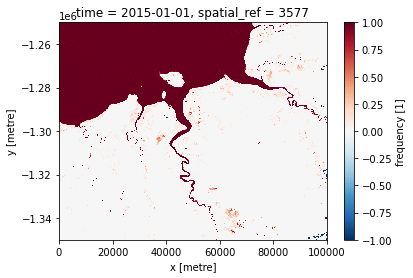

In [10]:
wofs_annual['frequency'].plot()

In [11]:
waterper = wofs_annual['frequency'].squeeze().drop('time')
waterper2 = np.zeros_like(waterper, dtype='float64')

# using wofs_annual_summary to seperate to pass in data as days (1-365) for waterpersistence
# code transforms this to categories from continuous input
waterper2 = np.where((waterper > 0) & (waterper <= 1), waterper*12*30, waterper2)

waterper_reclass = xr.DataArray(waterper2,
                                    coords={'y': waterper['y'].values,
                                            'x': waterper['x'].values},
                                    dims=['y', 'x'])

waterper_reclass_ds = waterper_reclass.to_dataset(name='waterper_wat_cin')
waterper_reclass_ds

<xarray.Dataset>
Dimensions:           (x: 1000, y: 1000)
Coordinates:
  * y                 (y) float64 -1.35e+06 -1.35e+06 ... -1.25e+06 -1.25e+06
  * x                 (x) float64 9.995e+04 9.985e+04 9.975e+04 ... 150.0 50.0
Data variables:
    waterper_wat_cin  (y, x) float64 0.0 0.0 0.0 0.0 ... 360.0 360.0 360.0 360.0

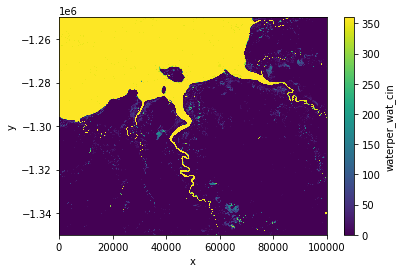

In [12]:
waterper_reclass_ds.waterper_wat_cin.plot()

## Implement new method

In [13]:
## Define consecutive count   
def consecutive_count(water_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
    '''
    function to get consective count of water (1) for each pixel across the time series

    :param numpy.array water_numpy: 3-D array of tv[z,y,x]
    :param numpy.array consecutive_numpy: bool output array for water (1) and not water (0)
    :param float required_consecutive: how many consectutive 1's to be classified as water?
    :param float consec_msk_val: what value to calculcate consectutives on
           default is water (1)     
    '''

    for y in range(water_numpy.shape[1]):
        for x in range(water_numpy.shape[2]):
            # If all the values are nan then just set output to nan and carry on
            pixel = water_numpy[:,y,x]

            if np.all(np.isnan(pixel)):
                consecutive_numpy[y,x] = np.nan
                continue            

            # Get counts of consecutive water classifications
            counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 1]

            if not counts:
                consecutive_numpy[y,x] = 0
            elif max(counts) >= required_consecutive:
                consecutive_numpy[y,x] = max(counts)
            else:
                consecutive_numpy[y,x] = 0

    return consecutive_numpy

In [14]:
wofs_daily

<xarray.Dataset>
Dimensions:      (time: 87, x: 1000, y: 1000)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-05T01:10:28.500000 ... 2015-12-31T01:11:48.500000
  * y            (y) float64 -1.35e+06 -1.35e+06 ... -1.25e+06 -1.25e+06
  * x            (x) float64 9.995e+04 9.985e+04 9.975e+04 ... 250.0 150.0 50.0
    spatial_ref  int32 3577
Data variables:
    water        (time, y, x) int16 64 64 64 64 64 64 ... 231 231 231 231 231
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [16]:
from datacube.storage import masking

# Need to mask out other values
data_nan = masking.mask_invalid_data(data)

# Create water and low-quality fc masks
no_water = np.invert( (data['water'] == 128) | (data['water'] == 132) )
high_ue = (data['UE'] > 30) & no_water

# Set to null areas with high UE, but no water
data_nan = data_nan.where(np.invert(high_ue))

# Don't need this anymore
data_nan = data_nan.drop("UE")
del high_ue

# Where there's water, set PV to 0
data_nan['PV'] = data_nan.PV.where(no_water, 0)
data_nan['NPV'] = data_nan.NPV.where(no_water, 0)

# Where there's water, set BS to 100
data_nan['BS'] = data_nan.BS.where(no_water, 100)

# don't need this anymore
data_nan = data_nan.drop("water")
del no_water

data_month = data_nan.groupby('time.month').median(dim='time')    

NameError: name 'data' is not defined

In [24]:
from datacube.storage import masking

data = wofs_daily

data_nan = masking.mask_invalid_data(data)

# Select clear and water pixels - binary
water = ((data.water == 128) | (data.water == 132)).to_dataset()
clear = ((data.water == 128) | (data.water == 132) | (data.water == 0)).to_dataset()
# print('Water',water)

# Group by month - total number of observations
water_month = water.groupby('time.month').sum(dim='time')   
clear_month = clear.groupby('time.month').sum(dim='time') 
clear_year = clear.groupby('time.year').sum(dim='time')   #just for testing

# Calculate frequency of water observations within the month
freq = water_month/clear_month

# Threshold frequency in month to get water or not
# Values greater than 0.5 kept
water_dominant = freq['water'] > 0.5
# Converted to binary
water_mask = water_dominant.where(freq['water'] >= 0)

# Make values of > 0.5 == 1 (end result in binary water mask)
# water_mask_drop = np.where(water_mask > 0.5, 1, water_mask)
water_mask_drop = np.where(freq['water'] > 0.5, 1, 0)
water_mask_xr = xr.DataArray(water_mask_drop, coords=water_mask.coords, dims=water_mask.dims)

# Pull tv as numpy array
water_numpy = water_mask_xr.values # equals water_mask_drop?
#print('NEW WATER PERSISTENCE',water_numpy)

# executing consecutive_count function #
# veg = 2 consecutive months
required_consecutive = 1

# Set up array for output (faster to pre-allocate for numba).
# Needs to be float32 for NaN
consecutive_numpy = np.empty((water_numpy.shape[1], water_numpy.shape[2]), dtype=np.float32)

# Run function to get array of with 1 where number of consecutive values for different
# dates is >= required_consecutive
print()
print('consecutive_numpy',consecutive_numpy.shape)
print()
print('water_numpy',water_numpy.shape)
consecutive_numpy = consecutive_count(water_numpy, consecutive_numpy, required_consecutive)

# reduce original array to 2D
# using max here but not important as we just want to use shape/attributes
water_reduce = water_mask.max(dim='month')

# create new data array with sampe dimensions as original
water_summary = xr.DataArray(consecutive_numpy, coords=water_reduce.coords, dims=water_reduce.dims)
print('water_summary',water_summary)

# currently each element of water_summary is whether it met the condition or not (i.e. 1 = at least 1 month)
# this needs to be converted to output days (or at least max consectutive months to the ben converted to days)
# changing the consecutive_count function the return the max counts rather than 1 if condition is met, max consectutive is now 12
# therefore water_summary (months) * 30 = days (max 360)
water_summary = water_summary*30.41

water_summary_ds = water_summary.to_dataset(name='waterper_wat_cin')
# water_summary_ds


consecutive_numpy (1000, 1000)

water_numpy (12, 1000, 1000)
water_summary <xarray.DataArray (y: 1000, x: 1000)>
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 11., 11., 11.],
       [ 0.,  0.,  0., ..., 12., 11., 11.],
       [ 0.,  0.,  0., ..., 11., 11., 11.]], dtype=float32)
Coordinates:
    spatial_ref  int32 3577
  * x            (x) float64 9.995e+04 9.985e+04 9.975e+04 ... 250.0 150.0 50.0
  * y            (y) float64 -1.35e+06 -1.35e+06 ... -1.25e+06 -1.25e+06


In [18]:
if len(water_dominant.coords['month'].values) == 12:
    print('12 months of data')

12 months of data


In [32]:
water_dominant

<xarray.DataArray 'water' (month: 12, y: 1000, x: 1000)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],

       ...,

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ..., False,  True,  True]]])
Coordinates:
  * x        (x) float64 9.995e+04 9.985e+04 9.975e+04 ... 250.0 150.0 50.0
  * y        (y) float64 -1.35e+06 -1.35e+06 -1.35e+06 ... -1.25e+06 -1.25e+06
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [ ]:
water_summary_ds.waterper_wat_cin.plot()

In [ ]:
# Set up subplots
f, axarr = plt.subplots(2, 3, figsize=(13, 11))
bands=['nbart_red', 'nbart_green', 'nbart_blue']

water.isel(time=6).water.plot(ax=axarr[0, 0])
axarr[0, 0].set_title('daily water binary')

clear.isel(time=6).water.plot(ax=axarr[0, 1])
axarr[0, 1].set_title('daily clear binary')

water_month.isel(month=0).water.plot(ax=axarr[0, 2])
axarr[0, 2].set_title('water month')

clear_month.isel(month=0).water.plot(ax=axarr[1, 0])
axarr[1, 0].set_title('clear month')

freq.isel(month=0).water.plot(ax=axarr[1, 1])
axarr[1, 1].set_title('freq month')

clear_year.water.plot(ax=axarr[1, 2])
axarr[1, 2].set_title('clear year')

In [18]:
## Change consecutive count function 

In [ ]:
## Define consecutive count   
def consecutive_count(water_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
    '''
    function to get consective count of water (1) for each pixel across the time series

    :param numpy.array water_numpy: 3-D array of tv[z,y,x]
    :param numpy.array consecutive_numpy: bool output array for water (1) and not water (0)
    :param float required_consecutive: how many consectutive 1's to be classified as water?
    :param float consec_msk_val: what value to calculcate consectutives on
           default is water (1)     
    '''

    for y in range(water_numpy.shape[1]):
        for x in range(water_numpy.shape[2]):
            # If all the values are nan then just set output to nan and carry on
            pixel = water_numpy[:,y,x]

            if np.all(np.isnan(pixel)):
                consecutive_numpy[y,x] = np.nan
                continue            

            # Get counts of consecutive water classifications
            counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 1]

            if not counts:
                consecutive_numpy[y,x] = 0
            elif max(counts) >= required_consecutive:
                consecutive_numpy[y,x] = max(counts)
            else:
                consecutive_numpy[y,x] = 0

    return consecutive_numpy